In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 16.4 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.25
batch_size_value = 32
n_repeats = 3
n_epochs = 50
lr = 1e-3
noise = 'topological'
# noise = 'salt&pepper'
# noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'gaussian':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:02<00:00, 4846.56it/s]



topological noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 4847.09it/s]


topological noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

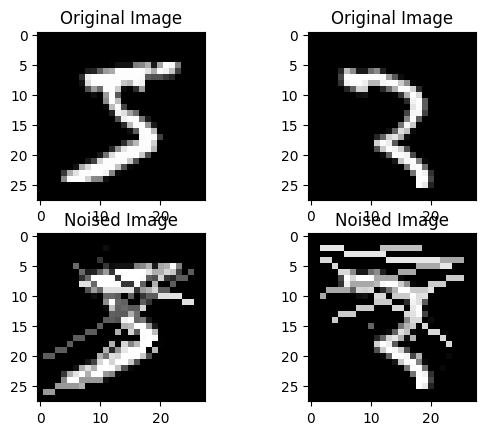

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

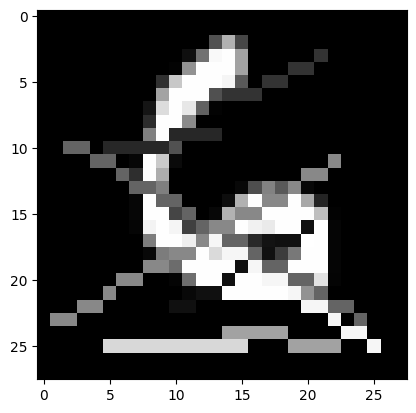

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

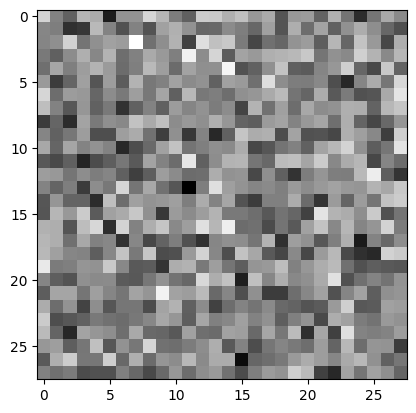

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(311.0061, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

2166.493408203125

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 313/313 [02:40<00:00,  1.96it/s]


  0 3879.2388 2114.8489


100%|██████████| 313/313 [02:36<00:00,  1.99it/s]


  1 2790.5796 2073.5017


100%|██████████| 313/313 [02:36<00:00,  2.01it/s]


  2 2549.6362 2053.9478


100%|██████████| 313/313 [02:35<00:00,  2.01it/s]


  3 2445.9119 2040.6785


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  4 2388.6062 2031.5695


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  5 2355.5903 2025.5759


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  6 2337.1367 2020.5431


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  7 2323.9739 2017.3418


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  8 2314.4185 2014.8618


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  9 2304.6777 2013.8275


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 10 2296.2542 2010.4749


100%|██████████| 313/313 [02:33<00:00,  2.03it/s]


 11 2289.2952 2010.5074


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 12 2283.5916 2008.2336


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 13 2277.1880 2006.6454


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 14 2272.8591 2005.4576


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 15 2269.9556 2004.1218


100%|██████████| 313/313 [02:30<00:00,  2.07it/s]


 16 2266.2473 2003.1014


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


 17 2263.2537 2002.2638


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


 18 2260.0342 2000.6549


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 19 2257.4292 1999.6888


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


 20 2255.6414 1999.1777


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 21 2252.9136 1997.9164


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 22 2250.6475 1996.6461


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 23 2249.6792 1996.6326


100%|██████████| 313/313 [02:36<00:00,  2.01it/s]


 24 2245.8635 1994.9948


100%|██████████| 313/313 [02:33<00:00,  2.03it/s]


 25 2243.9817 1993.7416


100%|██████████| 313/313 [02:33<00:00,  2.03it/s]


 26 2243.0312 1993.1215


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 27 2241.3503 1993.3468


100%|██████████| 313/313 [02:36<00:00,  2.01it/s]


 28 2239.3003 1992.3385


100%|██████████| 313/313 [02:36<00:00,  1.99it/s]


 29 2237.4404 1992.5116


100%|██████████| 313/313 [02:36<00:00,  1.99it/s]


 30 2235.9138 1990.5732


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 31 2233.7634 1990.8748


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 32 2231.7246 1990.7727


100%|██████████| 313/313 [02:30<00:00,  2.09it/s]


 33 2229.3977 1989.5226


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 34 2226.6816 1989.0895


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 35 2224.1577 1988.7852


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 36 2220.8181 1988.4349


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


 37 2218.5168 1988.8182


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


 38 2215.7053 1989.1270


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 39 2212.1497 1988.0483


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


 40 2208.8977 1988.1787


100%|██████████| 313/313 [02:30<00:00,  2.07it/s]


 41 2205.6506 1988.5924


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


 42 2202.1182 1987.8501


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 43 2200.6399 1988.4432


100%|██████████| 313/313 [02:28<00:00,  2.10it/s]


 44 2197.8406 1988.4073


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 45 2195.2932 1989.0852


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 46 2192.7971 1989.2985


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


 47 2190.4221 1988.3402


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 48 2187.9736 1988.0643


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 49 2185.3357 1988.6450

  2 MSE    Topo  


100%|██████████| 313/313 [02:36<00:00,  1.99it/s]


  0 3914.6294 2106.2021


100%|██████████| 313/313 [02:36<00:00,  2.01it/s]


  1 2799.7764 2073.8247


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


  2 2554.5273 2043.8571


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  3 2443.8340 2043.1554


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


  4 2376.7793 2034.6296


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  5 2341.8984 2027.0052


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  6 2324.7932 2022.7133


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  7 2313.2322 2018.2556


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  8 2305.9517 2001.7905


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  9 2300.5586 2000.2516


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 10 2293.8098 1998.3866


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 11 2289.5479 1996.3916


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 12 2286.9644 1994.2365


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 13 2282.4104 1994.2632


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


 14 2278.9490 1992.9943


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 15 2274.5422 1991.0271


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 16 2272.2681 1987.7991


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 17 2269.2021 1988.5612


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 18 2268.1038 1986.5583


100%|██████████| 313/313 [02:33<00:00,  2.05it/s]


 19 2265.2705 1984.9808


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 20 2262.3572 1984.6807


100%|██████████| 313/313 [02:33<00:00,  2.05it/s]


 21 2261.2317 1984.0814


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 22 2258.9404 1982.7620


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 23 2256.3850 1982.7738


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 24 2255.2600 1980.1805


100%|██████████| 313/313 [02:33<00:00,  2.05it/s]


 25 2252.3179 1978.7408


100%|██████████| 313/313 [02:33<00:00,  2.05it/s]


 26 2250.6199 1977.9108


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 27 2246.9487 1976.4937


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


 28 2244.7598 1976.6168


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 29 2241.6667 1976.0842


100%|██████████| 313/313 [02:35<00:00,  2.02it/s]


 30 2238.4629 1975.2201


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 31 2235.7654 1975.3379


100%|██████████| 313/313 [02:35<00:00,  2.01it/s]


 32 2232.4048 1974.9489


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 33 2228.5686 1975.7629


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 34 2223.7034 1975.3137


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


 35 2221.4009 1973.9285


100%|██████████| 313/313 [02:29<00:00,  2.10it/s]


 36 2217.0667 1973.1626


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 37 2215.3359 1974.2836


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 38 2211.7832 1974.2820


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 39 2208.3374 1974.2120


100%|██████████| 313/313 [02:29<00:00,  2.10it/s]


 40 2205.3801 1973.4479


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 41 2202.1062 1974.6270


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 42 2199.5642 1974.0220


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


 43 2197.5234 1974.5314


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 44 2192.7122 1973.4664


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


 45 2190.5127 1973.3790


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


 46 2187.3647 1974.0717


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 47 2184.4395 1973.6354


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 48 2182.4460 1973.8567


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 49 2180.2781 1974.3734

  3 MSE    Topo  


100%|██████████| 313/313 [02:35<00:00,  2.01it/s]


  0 3952.7148 2099.1775


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  1 2838.0752 2061.3491


100%|██████████| 313/313 [02:35<00:00,  2.02it/s]


  2 2574.0093 2043.0192


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


  3 2451.9333 2035.4501


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


  4 2385.7285 2021.3464


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


  5 2353.7456 2012.0140


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  6 2333.0710 2006.9225


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  7 2318.5464 2004.8351


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  8 2307.8704 2001.5645


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  9 2301.0415 1999.6969


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 10 2294.7776 1997.0072


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 11 2289.1848 1996.1464


100%|██████████| 313/313 [02:33<00:00,  2.03it/s]


 12 2284.5420 1993.8523


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 13 2279.6685 1991.8798


100%|██████████| 313/313 [02:33<00:00,  2.03it/s]


 14 2276.3606 1992.6702


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 15 2271.5867 1998.9441


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 16 2266.8782 2002.7010


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 17 2263.2820 2001.4165


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


 18 2261.3416 2000.8335


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 19 2259.1245 1989.4547


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 20 2255.8062 1985.0496


100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


 21 2252.1299 1984.0323


100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


 22 2249.1416 1982.7670


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 23 2245.4436 1982.0979


100%|██████████| 313/313 [02:35<00:00,  2.01it/s]


 24 2242.2546 1982.6494


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 25 2239.4531 1981.6702


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 26 2235.5918 1980.2366


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 27 2231.9678 1979.6686


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 28 2228.7117 1978.7727


100%|██████████| 313/313 [02:33<00:00,  2.03it/s]


 29 2226.3560 1977.6652


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


 30 2223.1526 1976.8785


100%|██████████| 313/313 [02:33<00:00,  2.03it/s]


 31 2221.7781 1976.8966


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 32 2219.0393 1976.2843


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


 33 2216.6238 1976.6865


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 34 2215.0688 1975.1917


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 35 2211.5139 1974.8829


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 36 2210.1763 1975.5056


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 37 2207.4592 1975.2402


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 38 2204.7297 1974.3254


100%|██████████| 313/313 [02:36<00:00,  2.01it/s]


 39 2202.3179 1974.2657


100%|██████████| 313/313 [02:33<00:00,  2.03it/s]


 40 2199.8025 1974.9395


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 41 2197.4302 1974.3063


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 42 2195.2312 1973.9705


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 43 2193.5830 1974.1030


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 44 2190.9094 1972.8490


100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


 45 2188.9751 1973.5983


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 46 2186.9497 1974.5239


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 47 2184.9634 1974.9230


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 48 2183.1597 1975.1915


100%|██████████| 313/313 [02:35<00:00,  2.01it/s]

 49 2182.0056 1974.1458

CPU times: user 12h 25min 45s, sys: 47 s, total: 12h 26min 32s
Wall time: 6h 23min 46s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

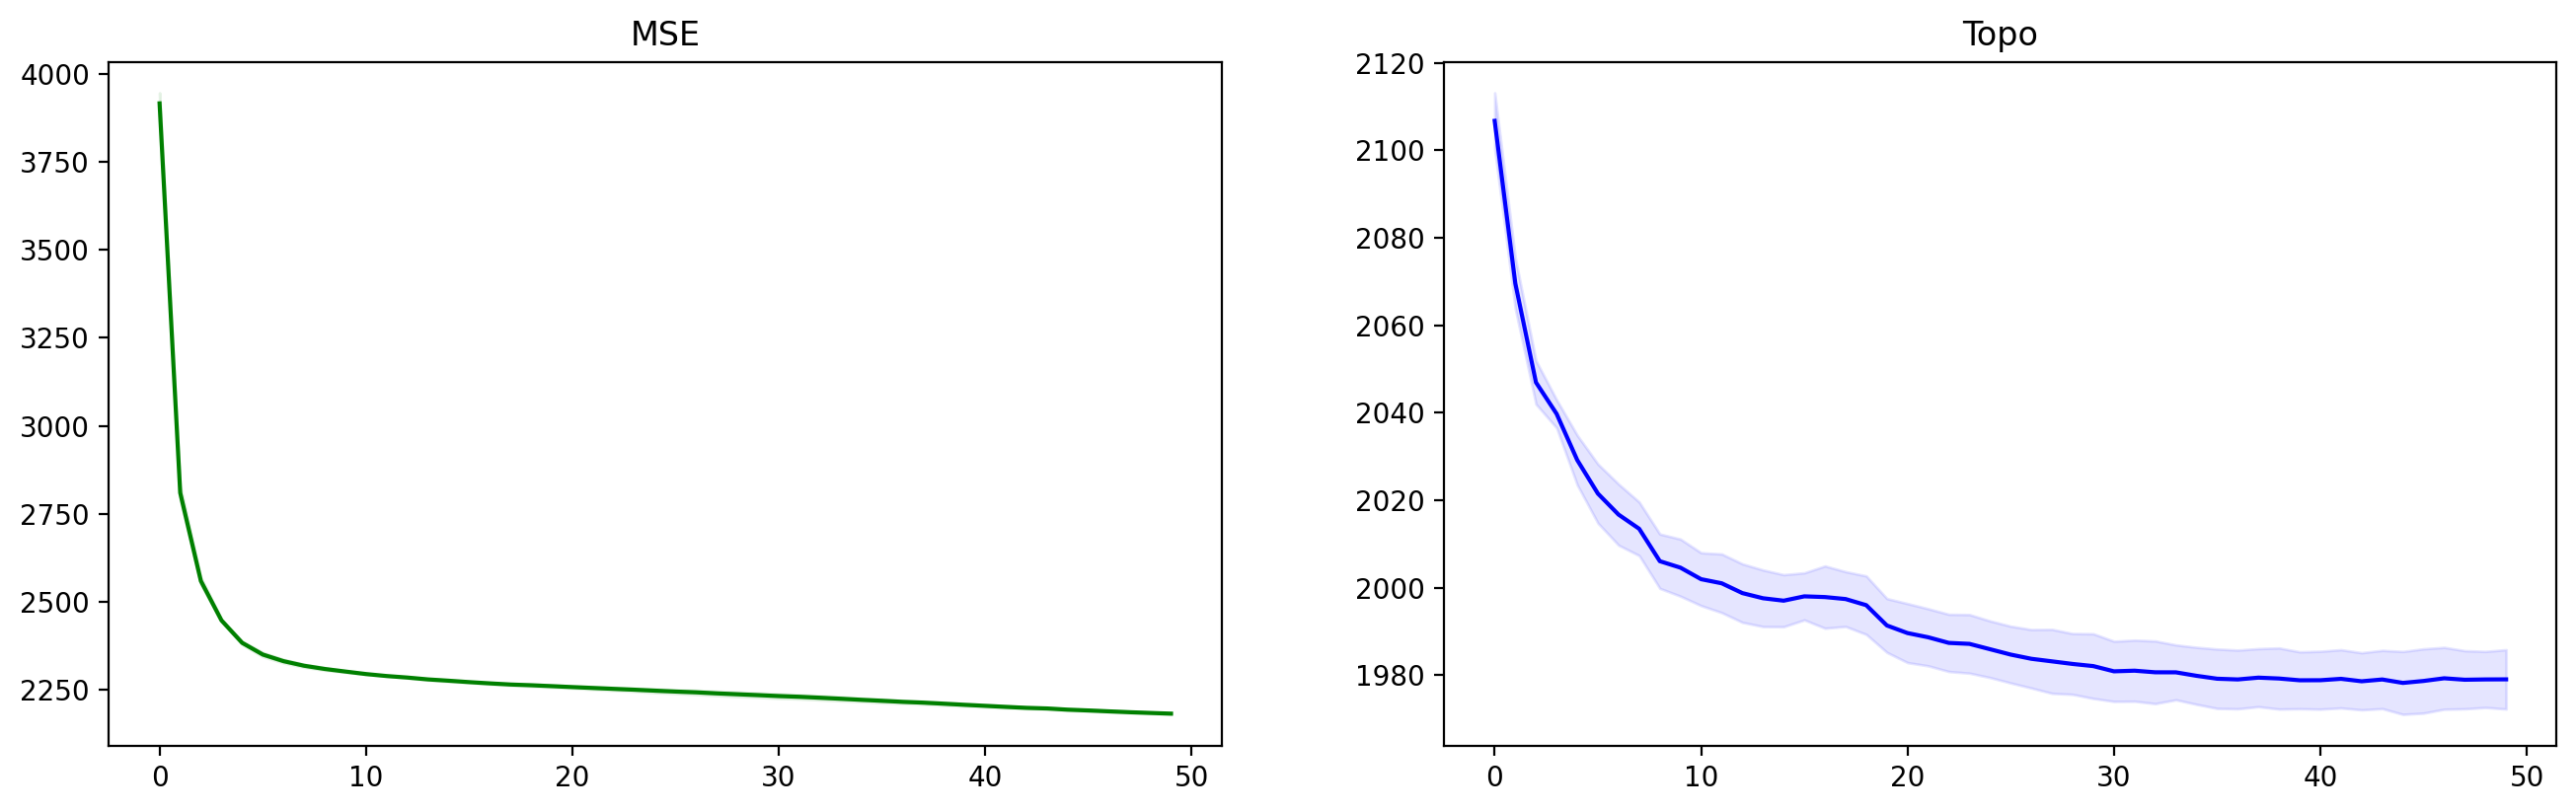

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

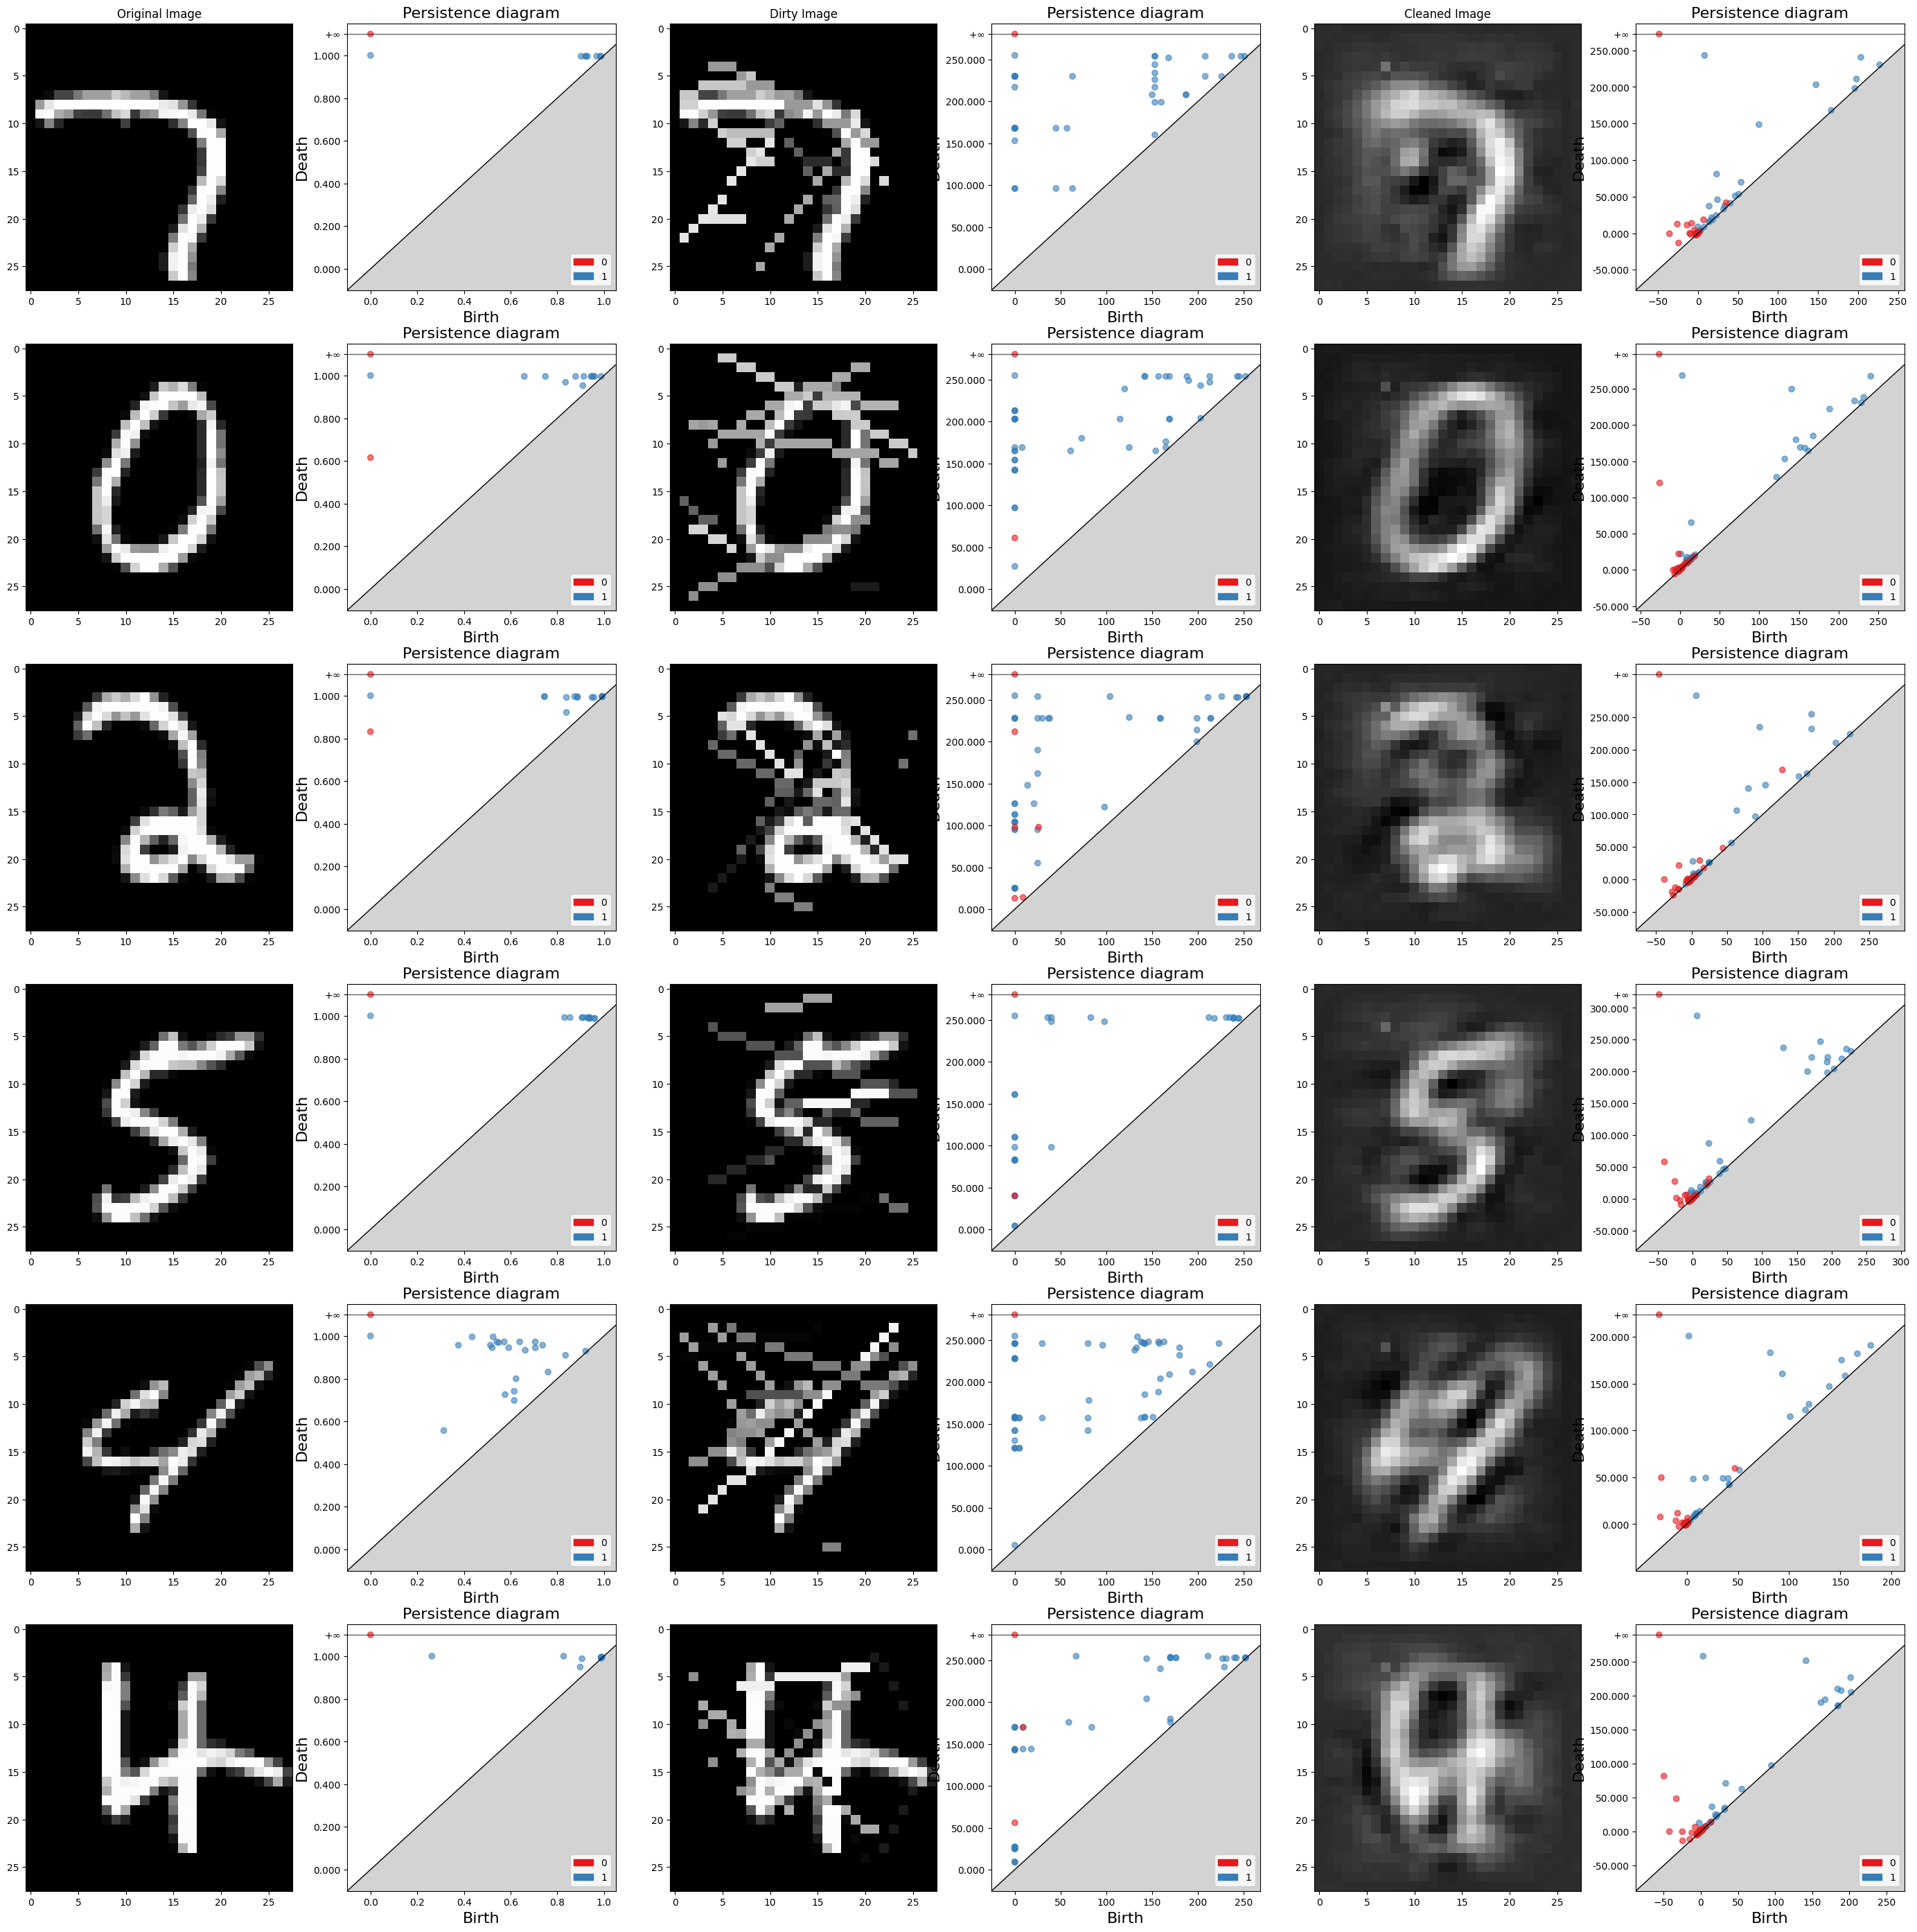

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[3879.23876953 2114.84887695]
  [2790.57958984 2073.50170898]
  [2549.63623047 2053.94775391]
  [2445.91186523 2040.6784668 ]
  [2388.60620117 2031.56945801]
  [2355.59033203 2025.57592773]
  [2337.13671875 2020.54309082]
  [2323.97387695 2017.34179688]
  [2314.41845703 2014.86181641]
  [2304.67773438 2013.82751465]
  [2296.25415039 2010.47485352]
  [2289.29516602 2010.50744629]
  [2283.59155273 2008.23364258]
  [2277.18798828 2006.64538574]
  [2272.85913086 2005.4576416 ]
  [2269.95556641 2004.12182617]
  [2266.24731445 2003.10144043]
  [2263.25366211 2002.26379395]
  [2260.03417969 2000.65490723]
  [2257.42919922 1999.68884277]
  [2255.64135742 1999.17773438]
  [2252.91357422 1997.91638184]
  [2250.64746094 1996.64611816]
  [2249.67919922 1996.63256836]
  [2245.86352539 1994.99475098]
  [2243.98168945 1993.74157715]
  [2243.03125    1993.12145996]
  [2241.3503418  1993.34680176]
  [2239.30029297 1992.33850098]
  [2237.44042969 1992.51159668]
  [2235.91381836 1990.57324219]
  [2233.